<a href="https://colab.research.google.com/github/queiyanglim/trading_algorithm/blob/master/pnl2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!git clone https://github.com/queiyanglim/trading_algorithm.git

In [2]:
import os
import numpy as np

os.getcwd()
os.chdir(r"/content/trading_algorithm")
!pip install pykalman

In [0]:
from oil_trading.brent_wti_kalman_spread.kalman_signal import *
from oil_trading.data.prepare_reuters_data import get_reuters_data
from oil_trading.brent_wti_kalman_spread.kalman_signal.trading_signal import kalman_regression_ZScore_signal
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime

mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['axes.linewidth'] = 0.01
plt.style.use("seaborn-whitegrid")

data = get_reuters_data("daily")

signal = kalman_regression_ZScore_signal(data, "wti", "brent")

In [4]:
signal.head()

,y,x,hr,hedged_spread,z_score,long_entry,long_exit,short_entry,short_exit,num_units_long,num_units_short
timestamp,,,,,,,,,,,
2014-05-23,110.54,104.35,-1.040132,2.002231,NaN,False,False,False,False,0.0,0.0
2014-05-26,110.32,104.24,-1.043644,1.530593,NaN,False,False,False,False,0.0,0.0
2014-05-27,110.02,104.11,-1.044819,1.243922,NaN,False,False,False,False,0.0,0.0
2014-05-28,109.81,102.72,-1.048340,2.124540,NaN,False,False,False,False,0.0,0.0
2014-05-29,109.97,103.58,-1.049152,1.298835,NaN,False,False,False,False,0.0,0.0


In [0]:
df = signal.copy()
df["position"] = df.num_units_long + df.num_units_short
df["enter"] = (df.long_entry & (df.position == 1)) | ((df.short_entry) & (df.position == -1))
df = df[["y", "x", "hr", "position", "enter"]]

capital = 100000

df["x_pos"] = np.nan
df["y_pos"] = np.nan
df = df.iloc[40:]
df.loc[(df.position == 0), ["x_pos", "y_pos"]] = 0

df.loc[df.enter,"y_pos"] = df.position * capital / df.y.loc[df.enter]
df.loc[df.enter,"x_pos"] = df.y_pos * df.hr
df.x_pos = df.x_pos.fillna(method="pad")
df.y_pos = df.y_pos.fillna(method ="pad")
df.to_csv("check_entry.csv")

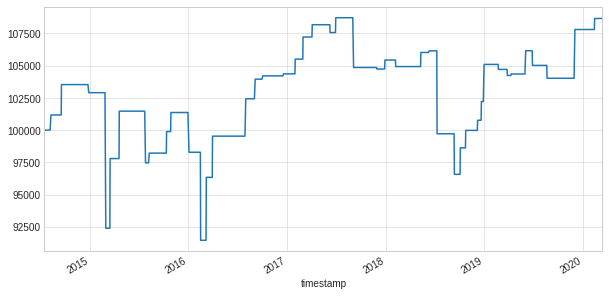

In [6]:
df_x = df[["x", "x_pos"]]
df_y = df[["y", "y_pos"]]

from pnl_process.static_position import *
ts_x_sum, ts_x = trade_summary(df_x, "x", "x_pos")
ts_y_sum, ts_y = trade_summary(df_y, "y", "y_pos")

total = ts_x + ts_y
total = total.cumsum() + capital
total.plot(figsize = (10,5))